# 1-2

In [4]:
using CSV 
using DataFrames
df = CSV.read("nfl_scores-2022.csv", DataFrame)

# Get first 8 weeks 
df_8 = filter(:week => x -> x <= 8, df)
print(df_8)
# Team mapping and home team margin 
SCORE_DIFF = Dict()

for row in eachrow(df_8)
    if row.tm_location == "H"
        ht = row.tm_name
        at = row.opp_name
        ht_margin = row.tm_score - row.opp_score
    elseif row.tm_location == "A"
        ht = row.opp_name
        at = row.tm_name
        ht_margin = row.opp_score - row.tm_score
    end
    SCORE_DIFF[(ht,at)] = ht_margin
end
# Get the set of TEAMS and GAMES (which are just the keys of our Dict())
# ’Football Team’ is the Washington football team
TEAMS = unique([ht for (ht,at) in keys(SCORE_DIFF)])
GAMES = keys(SCORE_DIFF)


123×7 DataFrame
 Row │ Column1  week   tm_name        opp_name       tm_location  tm_score  opp_score 
     │ Int64    Int64  String15       String15       String1      Int64     Int64     
─────┼────────────────────────────────────────────────────────────────────────────────
   1 │       0      1  Bills          Rams           A                  31         10
   2 │       1      1  Saints         Falcons        A                  27         26
   3 │       2      1  Browns         Panthers       A                  26         24
   4 │       3      1  Bears          49ers          H                  19         10
   5 │       4      1  Steelers       Bengals        A                  23         20
   6 │       5      1  Texans         Colts          H                  20         20
   7 │       6      1  Eagles         Lions          A                  38         35
   8 │       7      1  Football Team  Jaguars        H                  28         22
   9 │       8      1  Dolphins    

KeySet for a Dict{Any, Any} with 123 entries. Keys:
  (String15("Steelers"), String15("Buccaneers"))
  (String15("Saints"), String15("Raiders"))
  (String15("Cowboys"), String15("Football Team"))
  (String15("Browns"), String15("Jets"))
  (String15("Football Team"), String15("Titans"))
  (String15("Jets"), String15("Dolphins"))
  (String15("Dolphins"), String15("Steelers"))
  (String15("Buccaneers"), String15("Packers"))
  (String15("Falcons"), String15("49ers"))
  (String15("Ravens"), String15("Browns"))
  (String15("Vikings"), String15("Lions"))
  (String15("Chargers"), String15("Seahawks"))
  (String15("Seahawks"), String15("Giants"))
  (String15("Falcons"), String15("Browns"))
  (String15("49ers"), String15("Seahawks"))
  (String15("Cardinals"), String15("Chiefs"))
  (String15("Saints"), String15("Seahawks"))
  (String15("Eagles"), String15("Steelers"))
  (String15("Panthers"), String15("Browns"))
  ⋮

In [31]:
using JuMP, HiGHS
# quadratic optimization using sum of squared errors
model = Model(HiGHS.Optimizer)
@variable(model, x[TEAMS])
@variable(model, h) # home field advantage
@objective(model, Min, sum((SCORE_DIFF[(ht,at)] - (x[ht] - x[at] + h))^2 for (ht,at) in GAMES))
set_silent(model)
optimize!(model)
# sort the teams by rating
sort!(TEAMS, by = t -> value(x[t]), rev = true)
println("Team ratings:")
for (i, t) in enumerate(TEAMS)
    print(t, ": ", value(x[t]), " | ")
    if i % 4 == 0
        println()
    end
end
println("Home field advantage: ", value(h))


Team ratings:
Bills: 16.963085612414478 | Eagles: 11.184903697074825 | Chiefs: 9.413173026994578 | Ravens: 7.680538916720321 | 
Cowboys: 7.103561010016927 | Bengals: 5.6559890056659 | Vikings: 5.07387351176564 | Jets: 3.749882022192262 | 
49ers: 3.6327939611199596 | Patriots: 3.1792258799550317 | Dolphins: 2.4566642007669586 | Giants: 2.3790515273696893 | 
Buccaneers: 1.8243599995265958 | Seahawks: 1.352418793767604 | Browns: 0.7631607130889844 | Jaguars: 0.48067356018669105 | 
Saints: 0.28820237682287325 | Packers: 0.2799071097697919 | Falcons: -0.0399233143422546 | Bears: -0.8083846937813243 | 
Titans: -0.8302474054924807 | Cardinals: -1.213222001741861 | Raiders: -1.945337062857414 | Football Team: -2.402190128811245 | 
Broncos: -2.4490466520371204 | Lions: -3.3133336642415037 | Steelers: -3.498026783593265 | Rams: -3.6974179949226897 | 
Chargers: -3.7347034672572383 | Panthers: -3.885067429781555 | Colts: -3.9014675041198372 | Texans: -7.135438972435574 | 
Home field advantage: 1.9

# 1-3

In [32]:
value(x["Chiefs"] - x["Bengals"] + h)

5.694193086141092

# 1-4

In [30]:
using JuMP, HiGHS

model = Model(HiGHS.Optimizer)

@variable(model, x[TEAMS])  # Team ratings
@variable(model, h)         # Home-field advantage
@variable(model, e[GAMES] >= 0)  # Auxiliary variables for absolute errors

for (ht, at) in GAMES
    diff = SCORE_DIFF[(ht, at)]
    @constraint(model, e[(ht, at)] >=  diff - (x[ht] - x[at] + h))  # e ≥ (error)
    @constraint(model, e[(ht, at)] >= -diff + (x[ht] - x[at] + h))   # e ≥ -(error)
end

# Minimize the sum of absolute errors
@objective(model, Min, sum(e))

set_silent(model)
optimize!(model)

# Print results
println("Team ratings (L1 loss):")
sort!(TEAMS, by = t -> value(x[t]), rev = true)
for (i, t) in enumerate(TEAMS)
    print(t, ": ", round(value(x[t]), digits=4), " | ")
    if i % 4 == 0
        println()
    end
end
println("Home field advantage: ", round(value(h), digits=4))

Team ratings (L1 loss):
Eagles: 14.25 | Bills: 10.0 | Cowboys: 8.75 | 49ers: 8.25 | 
Cardinals: 5.75 | Bengals: 5.25 | Chiefs: 4.25 | Vikings: 4.25 | 
Chargers: 3.0 | Titans: 1.5 | Raiders: 1.25 | Ravens: 0.5 | 
Giants: 0.0 | Jets: -0.25 | Saints: -0.5 | Browns: -0.75 | 
Dolphins: -1.75 | Broncos: -2.0 | Seahawks: -2.75 | Falcons: -3.25 | 
Football Team: -3.5 | Packers: -3.75 | Panthers: -4.5 | Patriots: -5.0 | 
Rams: -5.0 | Colts: -5.75 | Steelers: -6.0 | Buccaneers: -6.25 | 
Bears: -6.25 | Lions: -7.5 | Texans: -7.5 | Jaguars: -7.75 | 
Home field advantage: 1.75


# 1-5

In [26]:
# Use the sum of squares model to predict week 9
week_9 = filter(:week => x -> x == 9, df)
num_games = size(week_9, 1)
correct_preds = 0

for row in eachrow(week_9)
    if row.tm_location == "H"
        ht = row.tm_name
        at = row.opp_name
        predicted_margin = value(x[ht]) - value(x[at]) + value(h)
        actual_margin = row.tm_score - row.opp_score

    elseif row.tm_location == "A"
        ht = row.opp_name  # The opponent is at home
        at = row.tm_name    # The current team is away
        predicted_margin = value(x[at]) - value(x[ht]) - value(h)  # Away team gets -h
        actual_margin = row.tm_score - row.opp_score  # Negative if away team loses

    end

    # Count correct win/loss predictions
    if sign(predicted_margin) == sign(actual_margin)
        correct_preds += 1
    end
end

accuracy = correct_preds / num_games

println("Week 9 Predictions:")
println("- Correct win/loss predictions: $correct_preds / $num_games ($(round(accuracy * 100, digits=2))%)")


Week 9 Predictions:
- Correct win/loss predictions: 8 / 13 (61.54%)


# 2-1

In [57]:
using JuMP, HiGHS, Printf

k = 60              
T = zeros(Int,k)   # vector of timepoints


m = Model(HiGHS.Optimizer) 
set_silent(m)

# Anakin's
@variable(m, xA[1:2,1:60])  #  position at each time
@variable(m, vA[1:2,1:60])  # velocity at each time
@variable(m, uA[1:2,1:60])  # thruster input at each time
@constraint(m, vA[1, 1] == 20) # 20 mph
@constraint(m, vA[2, 1] == 0)  
@constraint(m, xA[:, 1] == [0, 0]) # start at origin



# Palpatine's
@variable(m, xP[1:2,1:60])  # position at each time
@variable(m, vP[1:2,1:60])  # velocity at each time
@variable(m, uP[1:2,1:60])  # thruster input at each time
@constraint(m, xP[:, 1] == [0, 0.5]) # 0.5 miles east
@constraint(m, vP[2, 1] == 30)
@constraint(m, vP[1, 1] == 0) 




@constraint(m, xA[:,60] .== xP[:,60]) # end at the same point
# model system dynamics
for t in 1:k - 1
    @constraint(m, xA[:,t+1] .== xA[:,t] + vA[:,t] / 3600)
    @constraint(m, vA[:,t+1] .== vA[:,t] + uA[:,t])
    @constraint(m, xP[:,t+1] .== xP[:,t] + vP[:,t] / 3600)
    @constraint(m, vP[:,t+1] .== vP[:,t] + uP[:,t])
end


# minimize 2-norm (squared) of acceleration
@objective(m, Min, sum(uA.^2) + sum(uP.^2))
optimize!(m)
println("Anakin's final position (North, East): (", value(xA[1,60]), ", ", value(xA[2,60]), ")")
println("Palpatine's final position: ", "(", value(xP[1,60]), ", ", value(xP[2,60]), ")")
println("Total energy used: ", round(value(objective_value(m)), digits=4))

Anakin's final position (North, East): (0.16387938327879534, 0.49581907341824305)
Palpatine's final position: (0.16387938327879534, 0.49581907341824305)
Total energy used: 105.9307


# 2-2

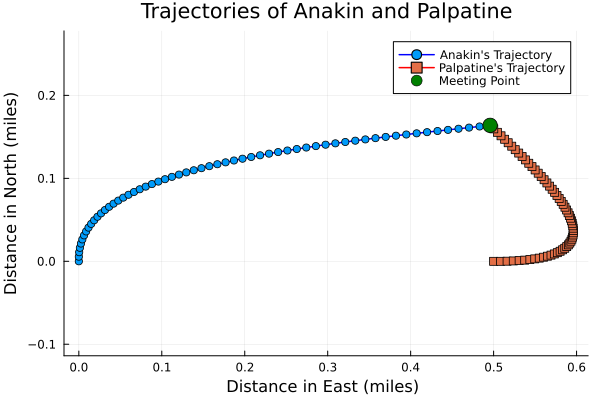

In [49]:
using Plots

# Retrieve the optimized trajectories as numerical matrices
xA_sol = value.(xA)  # Anakin's positions: 2-by-k matrix
xP_sol = value.(xP)  # Palpatine's positions: 2-by-k matrix

# Define the number of timesteps (k should be 60 in your case)
k = size(xA, 2)

# Plot Anakin's trajectory (blue) and Palpatine's trajectory (red)
plot(xA_sol[2, :], xA_sol[1, :],
     label="Anakin's Trajectory",
     linecolor=:blue,
     marker=:circle,
     markersize=4,
     linewidth=1.5)
plot!(xP_sol[2, :], xP_sol[1, :],
      label="Palpatine's Trajectory",
      linecolor=:red,
      marker=:square,
      markersize=4,
      linewidth=1.5)

# Since we enforced that they meet at the final time step, plot the meeting point
final_point = xA_sol[:, k]  # should be the same as xP_sol[:, k]
scatter!([final_point[2]], [final_point[1]],
         color=:green,
         markersize=8,
         label="Meeting Point")

# Adjust plot appearance
xlabel!("Distance in East (miles) ")
ylabel!("Distance in North (miles)")
title!("Trajectories of Anakin and Palpatine")
plot!(aspect_ratio=:equal)



# 2-3

In [50]:
using JuMP, HiGHS, Printf

k = 60              
T = zeros(Int,k)   # vector of timepoints


m = Model(HiGHS.Optimizer) 
set_silent(m)

# Anakin's
@variable(m, xA[1:2,1:60])  #  position at each time
@variable(m, vA[1:2,1:60])  # velocity at each time
@variable(m, uA[1:2,1:60])  # thruster input at each time
@constraint(m, vA[1, 1] == 20) # 20 mph
@constraint(m, vA[2, 1] == 0)  
@constraint(m, xA[:, 1] == [0, 0]) # start at origin



# Palpatine's
@variable(m, xP[1:2,1:60])  # position at each time
@variable(m, vP[1:2,1:60])  # velocity at each time
@variable(m, uP[1:2,1:60])  # thruster input at each time
@constraint(m, xP[:, 1] == [0, 0.5]) # 0.5 miles east
@constraint(m, vP[2, 1] == 30)
@constraint(m, vP[1, 1] == 0) 




@constraint(m, xA[:,60] .== xP[:,60]) # end at the same point
# end with velocity 0
@constraint(m, vA[:,60] .== 0)
@constraint(m, vP[:,60] .== 0)
# model system dynamics
for t in 1:k - 1
    @constraint(m, xA[:,t+1] .== xA[:,t] + vA[:,t] / 3600)
    @constraint(m, vA[:,t+1] .== vA[:,t] + uA[:,t])
    @constraint(m, xP[:,t+1] .== xP[:,t] + vP[:,t] / 3600)
    @constraint(m, vP[:,t+1] .== vP[:,t] + uP[:,t])
end


# minimize 2-norm (squared) of acceleration
@objective(m, Min, sum(uA.^2) + sum(uP.^2))
optimize!(m)
println("Anakin's final position: ", value(xA[1,60]), ", ", value(xA[2,60]))
println("Palpatine's final position: ", value(xP[1,60]), ", ", value(xP[2,60]))
println("Total energy used: ", round(value(objective_value(m)), digits=4))

Anakin's final position: 0.08333214501120183, 0.37499821700524566
Palpatine's final position: 0.08333214501120183, 0.37499821700524566
Total energy used: 245.5874


# 2-4

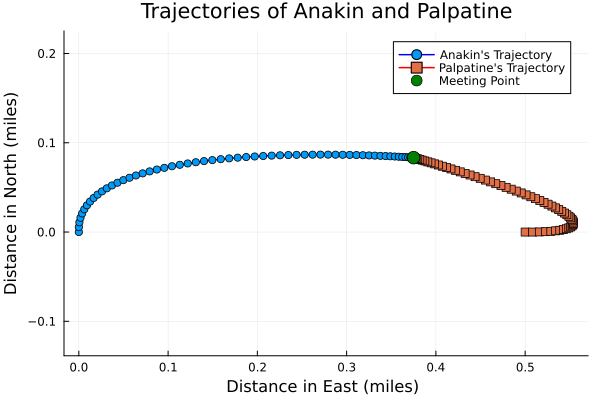

In [53]:
using Plots

# Retrieve the optimized trajectories as numerical matrices
xA_sol = value.(xA)  # Anakin's positions: 2-by-k matrix
xP_sol = value.(xP)  # Palpatine's positions: 2-by-k matrix

# Define the number of timesteps (k should be 60 in your case)
k = size(xA, 2)

# Plot Anakin's trajectory (blue) and Palpatine's trajectory (red)
plot(xA_sol[2, :], xA_sol[1, :],
     label="Anakin's Trajectory",
     linecolor=:blue,
     marker=:circle,
     markersize=4,
     linewidth=1.5)
plot!(xP_sol[2, :], xP_sol[1, :],
      label="Palpatine's Trajectory",
      linecolor=:red,
      marker=:square,
      markersize=4,
      linewidth=1.5)

# Since we enforced that they meet at the final time step, plot the meeting point
final_point = xA_sol[:, k]  # should be the same as xP_sol[:, k]
scatter!([final_point[2]], [final_point[1]],
         color=:green,
         markersize=7,
         label="Meeting Point")

# Adjust plot appearance
xlabel!("Distance in East (miles) ")
ylabel!("Distance in North (miles)")
title!("Trajectories of Anakin and Palpatine")
plot!(aspect_ratio=:equal)


# 3-2

In [94]:
using DataFrames, CSV, LinearAlgebra, NamedArrays

df = CSV.read("folio_mean.csv", DataFrame, header=false, delim=',')
(n,mmm) = size(df)

# Weekly numbers to annual, write as percentages (and flip returns to make more positive)
mu = -100/7*365*Vector(df[1:n,1])

df2 = CSV.read("folio_cov.csv",DataFrame,header=false,delim=',')

# Weekly numbers to annual, write as percentages, also reduce the risk a bit
Q = 0.5* (100/7*365)^2 * Matrix(df2) 

# Read the portfolio holding and benchmarks

df3 = CSV.read("folio_holding_benchmark.csv", DataFrame, header=false, delim=',')

h = Vector(df3[1:n,1])
b = Vector(df3[1:n,2])

# Current tracking risk 
benchmark_return = mu'b

# Current holdings return 
holdings_return = mu'*h 

# Current tracking risk 
active_risk = sqrt((h-b)'Q*(h-b))

println("Benchmark expected return: ", benchmark_return)
println("Holdings expected return: ", holdings_return)
println("Active Risk: ", active_risk)

Benchmark expected return: 9.48798378650461
Holdings expected return: 5.67073489826738
Active Risk: 32.90926641232401


In [97]:
using JuMP, Gurobi

# h = current holdings (40 assets have values, others are 0), vector of length 225
# b = Linde50 benchmark weights, vector of length 225
# Q = covariance matrix of size 225×225
# total_assets = 1e9 (1 billion dollars)

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "NonConvex", 2)  # Allow quadratic constraints
set_optimizer_attribute(model, "OutputFlag", 0)

# Variables
@variable(model, x[1:225] >= 0)          # New holdings (as fractions)
@variable(model, y[1:225] >= 0)        # Fraction of each asset to y
@variable(model, z[1:225] >= 0)       # Fraction of each asset to z

# Constraint 1: Portfolio must remain fully invested
@constraint(model, sum(x) == 1)

# Constraint 2: Active risk ≤ 10% 
@constraint(model, (x - b)' * Q * (x - b) <= 100)

# Constraint 3: Transaction accounting for each asset
@constraint(model, [i=1:225], x[i] == h[i] + y[i] - z[i])

# Objective: Minimize total transaction dollars (y + z in percentage terms)
@objective(model, Min, sum(y[i] + z[i] for i in 1:225))

optimize!(model)

# Convert percentages to dollars
total_transaction = 1e9 * value(sum(y + z))
expected_return = round(value(sum(mu[i] * x[i] for i in 1:225)), digits=4)
new_active_risk = round(sqrt(value((x - b)' * Q * (x - b))), digits=1)
println("Minimum transaction amount: \$", round(total_transaction, digits=2))
println("Expected return: ", expected_return, "%")
println("New active risk: ", new_active_risk, "%")

Set parameter Username
Set parameter LicenseID to value 2651061
Academic license - for non-commercial use only - expires 2026-04-14
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Minimum transaction amount: $1.09306014134e9
Expected return: 8.9754%
New active risk: 10.0%


# 3-3

Set parameter Username
Set parameter LicenseID to value 2651061
Academic license - for non-commercial use only - expires 2026-04-14
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter Username
Set parameter LicenseID to value 2651061
Academic license - for non-commercial use only - expires 2026-04-14
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter Username
Set parameter LicenseID to value 2651061
Academic license - for non-commercial use only - expires 2026-04-14
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter Username
Set parameter LicenseID to value 2651061
Academic license - for non-commercial use only - expires 2026-04-14
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter Username
Set parameter LicenseID to value 2651061
Academic license - for non-commercial use only - expires 2026-04-14
Set parameter NonConvex to value 2
Set parameter NonConvex t

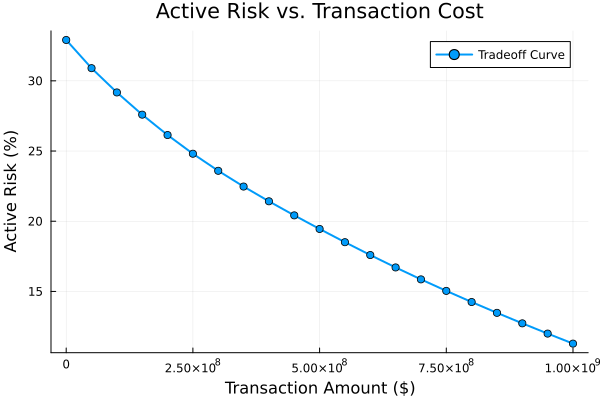

In [98]:
# plot the tradeoff curve for transaction amounts from 0 to 1B, with step size 50M
function trade(total_trans_amount; verbose=false)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "NonConvex", 2)
    set_optimizer_attribute(model, "OutputFlag",0)

    @variable(model, x[1:225] >= 0)  # New holdings
    @variable(model, buy[1:225] >= 0)  # Fraction bought
    @variable(model, sell[1:225] >= 0)  # Fraction sold

    # Portfolio fully invested
    @constraint(model, sum(x) == 1)

    # Total transaction constraint
    @constraint(model, sum(buy + sell) <= total_trans_amount / 1e9)

    # Holdings update
    @constraint(model, [i=1:225], x[i] == h[i] + buy[i] - sell[i])

    # Minimize active risk
    @objective(model, Min, (x - b)' * Q * (x - b))

    optimize!(model)

    total_trans = 1e9 * value(sum(buy + sell))
    active_risk = sqrt(value((x - b)' * Q * (x - b))) 
    return total_trans, active_risk
end

# Generate tradeoff curve
transaction_amounts = 0:50e6:1e9
risks = []
for amount in transaction_amounts
    _, risk = trade(amount)
    push!(risks, risk)
end

using Plots
plot(transaction_amounts, risks,
    xlabel="Transaction Amount (\$)",
    ylabel="Active Risk (%)",
    label="Tradeoff Curve",
    linewidth=2,
    markershape=:circle,
    title="Active Risk vs. Transaction Cost"
)


# 4-1

In [102]:
using JuMP
using Cbc

model = Model(Cbc.Optimizer)

plants = 1:3
bakeries = 1:3

fixed_costs = [10000, 11000, 9000]
s = [1600, 1500, 1200]
d = [1600, 900, 1000]

transport_costs = [
    15 10 12;
    20 18 21;
    17 15 11
]

@variable(model, z[i in plants], Bin)
@variable(model, t[i in plants, j in bakeries] >= 0)

@objective(model, Min, 
    sum(fixed_costs[i] * z[i] for i in plants) + 
    sum(transport_costs[i,j] * t[i,j] for i in plants, j in bakeries)
)

@constraint(model, [i in plants], sum(t[i,j] for j in bakeries) <= s[i] * z[i])
@constraint(model, [j in bakeries], sum(t[i,j] for i in plants) >= d[j])

optimize!(model)

Minimum Cost: $77900
Plants to Open: [1, 2, 3]
Shipments:
Plant 1 → Bakery 1: 700 units
Plant 1 → Bakery 2: 900 units
Plant 2 → Bakery 1: 700 units
Plant 3 → Bakery 1: 200 units
Plant 3 → Bakery 3: 1000 units
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Oct 26 2022 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 72033.3 - 0.00 seconds
Cgl0004I processed model has 6 rows, 12 columns (3 integer (3 of which binary)) and 21 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.466667
Cbc0038I Pass   1: suminf.    0.46667 (1) obj. 72033.3 iterations 0
Cbc0038I Solution found of 77900
Cbc0038I Relaxing continuous gives 77900
Cbc0038I Before mini branch and bound, 2 integers at bound fixed and 4 continuous
Cbc0038I Full problem 6 rows 12 columns, reduced to 1 rows 3 columns
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I Round again with cutoff of 77313.3
Cbc0038I Reduced cost fixing fi

In [103]:
if termination_status(model) == MOI.OPTIMAL
    println("Minimum Cost: \$", round(Int, objective_value(model)))
    println("Plants to Open: ", [i for i in plants if value(z[i]) > 0.5])
    println("Shipments:")
    for i in plants
        for j in bakeries
            qty = round(Int, value(t[i,j]))
            if qty > 0
                println("Plant $i → Bakery $j: $qty units")
            end
        end
    end
else
    println("No optimal solution found.")
end


Minimum Cost: $77900
Plants to Open: [1, 2, 3]
Shipments:
Plant 1 → Bakery 1: 700 units
Plant 1 → Bakery 2: 900 units
Plant 2 → Bakery 1: 700 units
Plant 3 → Bakery 1: 200 units
Plant 3 → Bakery 3: 1000 units


# 5-2

In [104]:
using JuMP, Cbc

# Define the model
model = Model(Cbc.Optimizer)

# Boiler data: [min steam, max steam, cost per ton]
boilers = [
    (400, 1000, 10),  # B1
    (200, 900, 8),     # B2
    (300, 800, 7)      # B3
]

# Turbine data: [min steam, max steam, KwH per ton, processing cost per ton]
turbines = [
    (300, 600, 4, 2),  # T1
    (500, 800, 5, 3),  # T2
    (600, 900, 6, 4)   # T3
]

required_power = 8000  # KwH

# Variables
@variable(model, y[1:3], Bin)  # 1 if boiler i is used
@variable(model, w[1:3], Bin)  # 1 if turbine j is used
@variable(model, x[1:3] >= 0)  # steam produced by boilers
@variable(model, z[1:3] >= 0)  # steam processed by turbines

# Boiler constraints
for i in 1:3
    min_steam, max_steam, _ = boilers[i]
    @constraint(model, x[i] >= min_steam * y[i])
    @constraint(model, x[i] <= max_steam * y[i])
end

# Turbine constraints
for j in 1:3
    min_steam, max_steam, _, _ = turbines[j]
    @constraint(model, z[j] >= min_steam * w[j])
    @constraint(model, z[j] <= max_steam * w[j])
end

# Steam balance: Total produced = total processed
@constraint(model, sum(x) == sum(z))

# Power requirement
@constraint(model, sum(turbines[j][3] * z[j] for j in 1:3) >= required_power)

# Objective: Minimize total cost (steam production + processing)
@objective(model, Min, 
    sum(boilers[i][3] * x[i] for i in 1:3) + 
    sum(turbines[j][4] * z[j] for j in 1:3)
)

# Solve the model
optimize!(model)

Optimal Solution Found!
Total Cost: $15720.0

Boiler Operations:
Boiler B1: OFF | Steam Produced: 0.0 tons
Boiler B2: ON | Steam Produced: 620.0 tons
Boiler B3: ON | Steam Produced: 800.0 tons

Turbine Operations:
Turbine T1: OFF | Steam Processed: 0.0 tons
Turbine T2: ON | Steam Processed: 520.0 tons
Turbine T3: ON | Steam Processed: 900.0 tons

Total Power Generated: 8000.0 KwH (Required: 8000 KwH)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Oct 26 2022 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 15720 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 9 rows, 9 columns (4 integer (4 of which binary)) and 28 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.311111
Cbc0038I Solution found of 15720
Cbc0038I Relaxing continuous gives 15720
Cbc0038I Before mini branch and bound, 3 integers at bound fixed and 3 continuous
Cbc0038I Mini br

In [105]:
if termination_status(model) == MOI.OPTIMAL
    println("Optimal Solution Found!")
    println("Total Cost: \$", round(objective_value(model), digits=2))

    println("\nBoiler Operations:")
    for i in 1:3
        println("Boiler B$i: ", value(y[i]) > 0.5 ? "ON" : "OFF",
                " | Steam Produced: ", round(value(x[i]), digits=2), " tons")
    end

    println("\nTurbine Operations:")
    for j in 1:3
        println("Turbine T$j: ", value(w[j]) > 0.5 ? "ON" : "OFF",
                " | Steam Processed: ", round(value(z[j]), digits=2), " tons")
    end

    total_power = sum(turbines[j][3] * value(z[j]) for j in 1:3)
    println("\nTotal Power Generated: ", total_power, " KwH")
else
    println("No optimal solution found.")
end

Optimal Solution Found!
Total Cost: $15720.0

Boiler Operations:
Boiler B1: OFF | Steam Produced: 0.0 tons
Boiler B2: ON | Steam Produced: 620.0 tons
Boiler B3: ON | Steam Produced: 800.0 tons

Turbine Operations:
Turbine T1: OFF | Steam Processed: 0.0 tons
Turbine T2: ON | Steam Processed: 520.0 tons
Turbine T3: ON | Steam Processed: 900.0 tons

Total Power Generated: 8000.0 KwH (Required: 8000 KwH)
